# Merge data and filter

In [1]:
import numpy as np
import pandas as pd
# import dask.dataframe as dd
from urllib.parse import urlparse

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy.sparse import load_npz

from tqdm import tqdm

## Load Data

In [2]:
# domain_index = pd.read_csv('../02_data/data_archive/raphaela/lasser/domain_pc1.csv')
# chat_index = np.load('../02_data/telegram/telegram/chat_index.npy')
# urls_sample = pd.read_csv('../02_data/url_sample_with_titles.csv')

In [3]:
domain_index = pd.read_csv('../02_data/domain_pc1.csv')
# chat_index = np.load('../02_data/chat_index.npy')
# urls_sample = pd.read_csv('../02_data/url_sample_with_titles.csv')

In [4]:
urls = pd.read_parquet('../02_data/url.data.parquet')

In [5]:
chat_url_shares = load_npz('../02_data/chat_url_shares.npz')

In [6]:
# print("Chat Index Shape:", chat_index.shape)
print(urls.head())

   index                                                url  \
0      0    https://odysee.com/@jermwarfare:2/The-Baileys:8   
1      1  https://drsambailey.com/its-elementary-my-dear...   
2      2  https://drsambailey.com/why-nobody-had-caught-...   
3      3  https://live.childrenshealthdefense.org/shows/...   
4      4  https://jonrappoport.substack.com/p/the-millio...   

                       domain  messages  chats  avalanches  \
0                  odysee.com        11      9          10   
1             drsambailey.com        18     14          13   
2             drsambailey.com       104     71          59   
3  childrenshealthdefense.org        31     24          18   
4                substack.com        24     20          14   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.100000                   2  0.327777              2   
1             1.384615                   4  0.323942              4   
2             1.762712             

### Jana Lasser PCA results (Groundtruth)

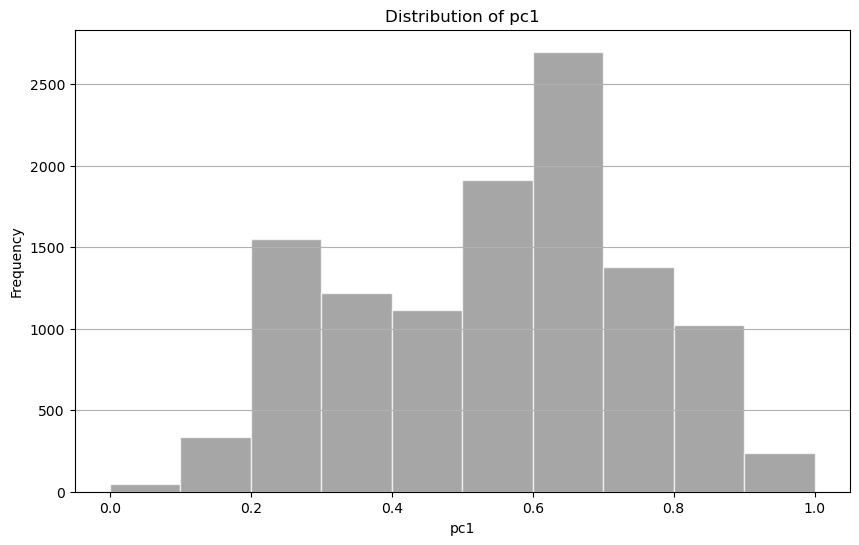

Top 5 rows with the highest pc1 scores:
                 domain       pc1
0           reuters.com  1.000000
1            apnews.com  0.998049
2  charitynavigator.org  0.985752
3          rollcall.com  0.982851
4    smithsonianmag.com  0.971184

Bottom 5 rows with the lowest pc1 scores:
                domain       pc1
11519  naturalnews.com  0.000000
11518    worldtruth.tv  0.017644
11517    davidicke.com  0.041614
11516    pandemic.news  0.043817
11513        rense.com  0.044752


In [7]:
# Plot the distribution of the 'pc1' column
plt.figure(figsize=(10, 6))
plt.hist(domain_index['pc1'], color='grey', alpha=0.7, edgecolor='white')
plt.title('Distribution of pc1')
plt.xlabel('pc1')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.savefig('../03_plots/hist_pc1.png')
plt.show()

# Show the row with the highest 'pc1' score
highest_scores = domain_index.nlargest(5, 'pc1')
print("Top 5 rows with the highest pc1 scores:")
print(highest_scores)

# Show the 5 rows with the lowest 'pc1' scores
lowest_scores = domain_index.nsmallest(5, 'pc1')
print("\nBottom 5 rows with the lowest pc1 scores:")
print(lowest_scores)

highest_scores = domain_index.nlargest(5, 'pc1')

# Show the 5 rows with the lowest 'pc1' scores
lowest_scores = domain_index.nsmallest(5, 'pc1')

# Combine both into a single table for export
highest_scores['Type'] = 'Highest'
lowest_scores['Type'] = 'Lowest'

combined_scores = pd.concat([highest_scores, lowest_scores])

# Export to CSV or Excel
combined_scores.to_csv('../03_plots/pc1_highest_lowest_scores.csv', index=False)

In [8]:
# Show the row with the highest 'pc1' score
highest_scores = domain_index.nlargest(20, 'pc1')
print("Top 5 rows with the highest pc1 scores:")
print(highest_scores)

Top 5 rows with the highest pc1 scores:
                      domain       pc1
0                reuters.com  1.000000
1                 apnews.com  0.998049
2       charitynavigator.org  0.985752
3               rollcall.com  0.982851
4         smithsonianmag.com  0.971184
5   climateactiontracker.org  0.970825
6                stripes.com  0.970706
7                  drugs.com  0.965143
8                    cbo.gov  0.964974
9            usaspending.gov  0.964974
10           africacheck.org  0.964974
11                nature.com  0.964534
12                   cdc.gov  0.964446
13           leadstories.com  0.963826
14       climatefeedback.org  0.963421
15  sandiegouniontribune.com  0.961103
16              indystar.com  0.957208
17                  nasa.gov  0.956316
18       hopkinsmedicine.org  0.956072
19             armytimes.com  0.955899


## Domain Index

In [9]:
# Step 2: Match domains with domain_index
urls = pd.merge(urls, domain_index, on='domain', how='inner')

# Display the first few rows of the merged DataFrame
print(urls.head())

# Drop rows where the domain was not found in domain_index
urls.dropna(subset=['pc1'], inplace=True)

   index                                                url  \
0      3  https://live.childrenshealthdefense.org/shows/...   
1     71  https://live.childrenshealthdefense.org/chd-tv...   
2    115  https://live.childrenshealthdefense.org/chd-tv...   
3    142  https://childrenshealthdefense.org/defender/ny...   
4    191  https://live.childrenshealthdefense.org/chd-tv...   

                       domain  messages  chats  avalanches  \
0  childrenshealthdefense.org        31     24          18   
1  childrenshealthdefense.org        63     46          48   
2  childrenshealthdefense.org        21     17          15   
3  childrenshealthdefense.org       193    119         121   
4  childrenshealthdefense.org        47     27          28   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.722222                   8  0.327384              8   
1             1.312500                   5  0.168732              4   
2             1.400000             

In [10]:
urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18141615 entries, 0 to 18141614
Data columns (total 17 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   url                  object        
 2   domain               object        
 3   messages             int64         
 4   chats                int64         
 5   avalanches           int64         
 6   mean_avalanche_size  float64       
 7   top_avalanche_size   int64         
 8   virality             float64       
 9   top_shares_1h        int64         
 10  top_shares_6h        int64         
 11  top_shares_1d        int64         
 12  top_shares_3d        int64         
 13  top_shares_14d       int64         
 14  first_share_date     datetime64[ns]
 15  final_share_date     datetime64[ns]
 16  pc1                  float64       
dtypes: datetime64[ns](2), float64(3), int64(10), object(2)
memory usage: 2.3+ GB


In [11]:
# Group by domain and count occurrences
domain_counts = urls['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'frequency']

# Preview the result
print(domain_counts.head())

              domain  frequency
0        youtube.com    1709043
1         google.com     901224
2         rumble.com     456786
3  independent.co.uk     444269
4          4chan.org     395536


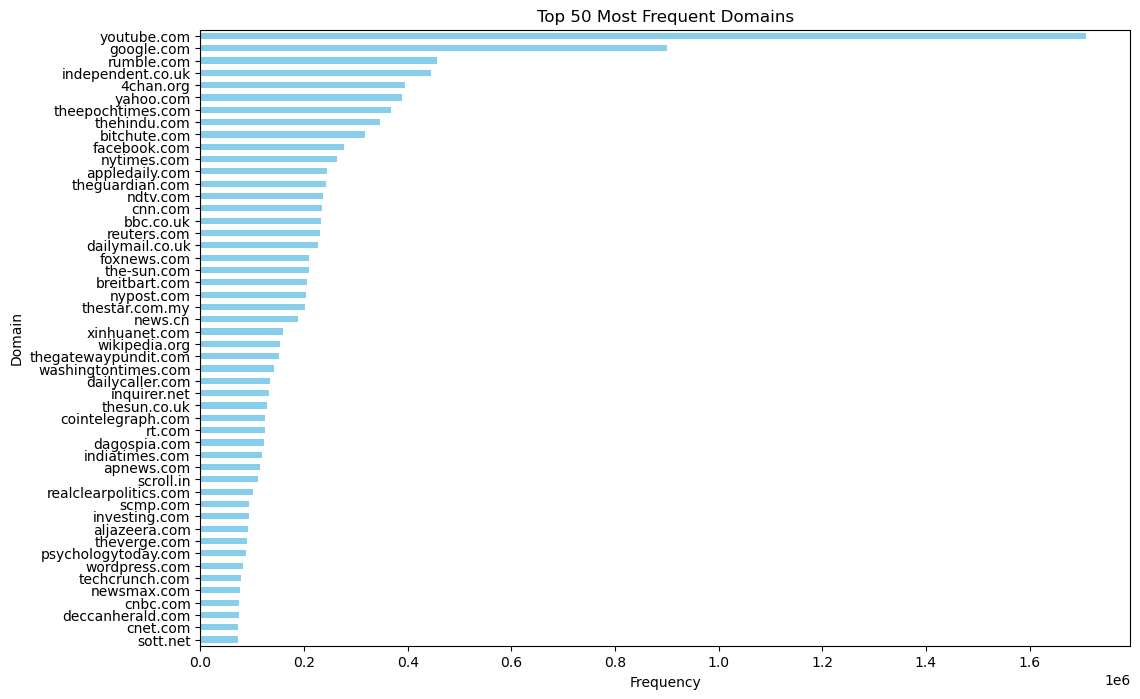

In [12]:
# Get the top 50 most frequent domains
top_domains = urls['domain'].value_counts().head(50)

# Plot the histogram
plt.figure(figsize=(12, 8))
top_domains.plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Frequent Domains')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [13]:
# Filter URLs that include "ift.tt"
ift_tt_urls = urls[urls['url'].str.contains("ift.tt", na=False)]

# Print a sample of the filtered URLs
print(ift_tt_urls.sample(5))  

            index                                                url  \
7931826  40917649  https://translate.google.com/translate?sl=sv&t...   
7931039  40915993  https://translate.google.com/translate?sl=sv&t...   
7927532  40908762  https://translate.google.com/translate?sl=sv&t...   
7940211  40931760  https://translate.google.com/translate?sl=sv&t...   
7923955  40901380  https://translate.google.com/translate?sl=sv&t...   

             domain  messages  chats  avalanches  mean_avalanche_size  \
7931826  google.com         1      1           1                  1.0   
7931039  google.com         1      1           1                  1.0   
7927532  google.com         1      1           1                  1.0   
7940211  google.com         1      1           1                  1.0   
7923955  google.com         2      1           2                  1.0   

         top_avalanche_size  virality  top_shares_1h  top_shares_6h  \
7931826                   1  1.000000              1     

## Drop Social Media

In [14]:
social_media_domains = [
    'facebook.com', 
    #'instagram.com', 'linkedin.com',
    #'tiktok.com', 'snapchat.com',
    'youtube.com', 'youtu.be',  
    #'twitter.com', 't.co', 't.me',
    #'reddit.com', 'redd.it',
    'google.com', 'feedproxy.google.com', 'goo.gl'
    # 'amzn.to', 'rumble.com' rumble could be scraped kinda efficient
    # 'bit.ly', 'tinyurl.com', 'ow.ly', 'buff.ly', 'shorte.st', 'is.gd', ift.tt link compression 
    # 'boards.4chan.org', '4chan.org' blog posting "social media" platform but not very known and active
    # 'telegra.ph' anonymous blog and article 
]

# Function to check if a URL is from a social media site
def is_social_media(url):
    try:
        return any(domain in url for domain in social_media_domains)
    except:
        return None

tqdm.pandas()

# Filter out rows where the URL is from a social media site
urls_filtered = urls[~urls['domain'].apply(is_social_media)]

# Check the cleaned DataFrame
print(urls_filtered.head())

num_social_media = len(urls) - len(urls_filtered)
print(f"Number of URLs filtered out: {num_social_media}")

   index                                                url  \
0      3  https://live.childrenshealthdefense.org/shows/...   
1     71  https://live.childrenshealthdefense.org/chd-tv...   
2    115  https://live.childrenshealthdefense.org/chd-tv...   
3    142  https://childrenshealthdefense.org/defender/ny...   
4    191  https://live.childrenshealthdefense.org/chd-tv...   

                       domain  messages  chats  avalanches  \
0  childrenshealthdefense.org        31     24          18   
1  childrenshealthdefense.org        63     46          48   
2  childrenshealthdefense.org        21     17          15   
3  childrenshealthdefense.org       193    119         121   
4  childrenshealthdefense.org        47     27          28   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.722222                   8  0.327384              8   
1             1.312500                   5  0.168732              4   
2             1.400000             

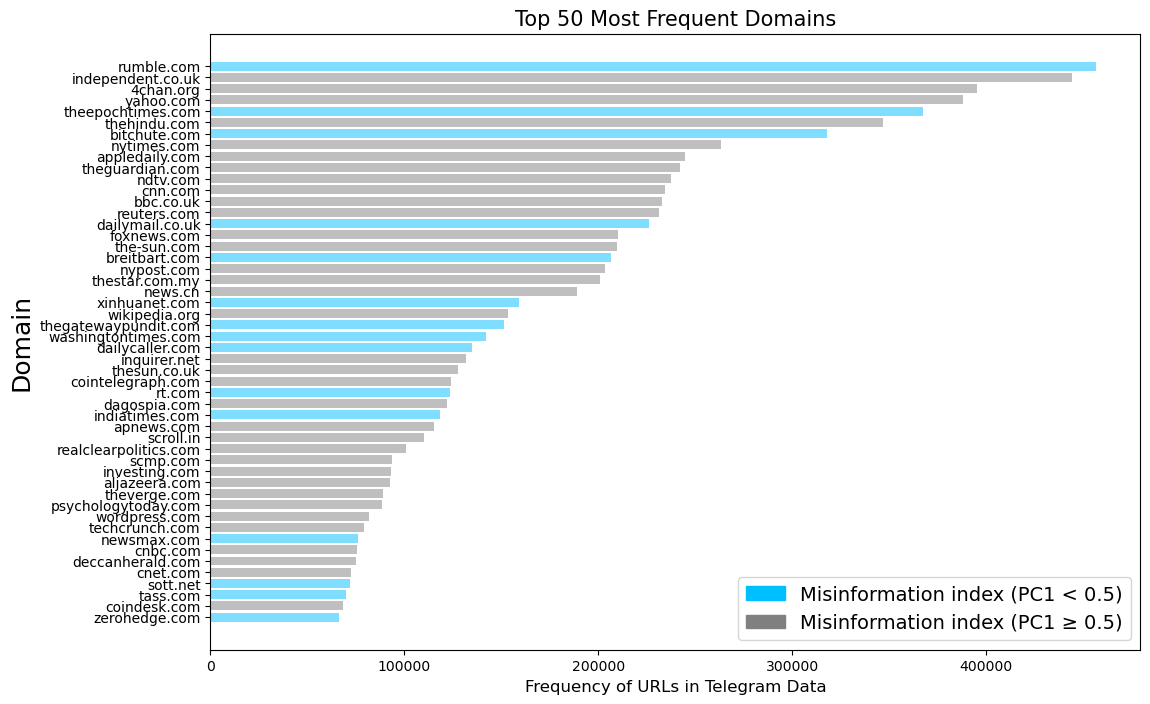

In [28]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Get the top 50 most frequent domains
top_domains_counts = urls_filtered['domain'].value_counts().head(50)

# Compute mean 'pc1' for each domain in the top 50
top_domains = (
    urls_filtered[urls_filtered['domain'].isin(top_domains_counts.index)]
    .groupby('domain')['pc1']
    .mean()
    .reindex(top_domains_counts.index)  # Ensure the order matches top_domains_counts
)

# Assign colors based on the 'pc1' column
colors = ['deepskyblue' if pc1_value < 0.5 else 'grey' for pc1_value in top_domains]

# Plot manually with adjusted font sizes
plt.figure(figsize=(12, 8))
bars = plt.barh(top_domains_counts.index, top_domains_counts.values, color=colors, alpha=0.5)

# Increase font sizes
plt.title('Top 50 Most Frequent Domains', fontsize=15)
plt.xlabel('Frequency of URLs in Telegram Data', fontsize=12)
plt.ylabel('Domain', fontsize=18)
plt.xticks() #fontsize=14
plt.yticks() #fontsize=14

# Invert y-axis so the most frequent domain is on top
plt.gca().invert_yaxis()

# Add legend with larger font size
blue_patch = mpatches.Patch(color='deepskyblue', label='Misinformation index (PC1 < 0.5)')
grey_patch = mpatches.Patch(color='grey', label='Misinformation index (PC1 ≥ 0.5)')
plt.legend(handles=[blue_patch, grey_patch], loc='lower right', fontsize=14)

# Save and show the plot
plt.savefig('../03_plots/most_frequent_domains.png')
plt.show()


In [83]:
domains = urls_filtered['domain'].unique()
len(domains)

7391

In [1]:
filtered_row = urls_filtered[urls_filtered['domain'] == 'theepochtimes.com']
filtered_row

NameError: name 'urls_filtered' is not defined

## Filter 1000 most forwarded url per domain

In [84]:
urls_filtered['rank'] = urls_filtered.groupby('domain')['top_shares_3d'].rank(ascending=False, method='first')

# Step 2: Filter to keep only the top 1000 rows per domain
top_100_filtered_df = urls_filtered[urls_filtered['rank'] <= 100]

# Step 3: Extract only the `url` column
top_100_filtered = top_100_filtered_df[['url', 'index']]
top_100_filtered.info()

/tmp/ipykernel_55617/2339978095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_filtered['rank'] = urls_filtered.groupby('domain')['top_shares_3d'].rank(ascending=False, method='first')


<class 'pandas.core.frame.DataFrame'>
Index: 360845 entries, 2 to 18141577
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     360845 non-null  object
 1   index   360845 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.3+ MB


In [85]:
domains = urls_filtered['domain'].unique()
len(domains)

7391

## Datetime

In [53]:
urls['first_share_date'] = pd.to_datetime(urls['first_share_date'])
urls['final_share_date'] = pd.to_datetime(urls['final_share_date'])
urls['year'] = urls['first_share_date'].dt.year

## Export

In [46]:
import os
folder_path = "../02_data/"

In [19]:
# Save the DataFrame as a CSV file in the '02_data' folder
csv_path = os.path.join(folder_path, 'url_domains.csv')
urls.to_csv(csv_path, index=False)

In [72]:
#csv_path = os.path.join(folder_path, 'top_1000_urls.csv')
#top_1000_urls.to_csv(csv_path, index=False)

top_100_filtered.to_csv('../02_data/top_100_filtered.csv', index=False)

In [55]:
# Compress and save the DataFrame as a .gz file
csv_gz_path = os.path.join(folder_path, 'top_100_urls.csv.gz')
top_1000_urls.to_csv(csv_gz_path, index=False, compression='gzip')